## Model Selection

This notebook should include preliminary and baseline modeling.
- Try as many different models as possible.
- Don't worry about hyperparameter tuning or cross validation here.
- Ideas include:
    - linear regression
    - support vector machines
    - random forest
    - xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
X_train = pd.read_csv("/Users/snoopy/GitHub/LHL-Project-3-Midterm-Project/notebooks/processed/X_train.csv")
y_train = pd.read_csv("/Users/snoopy/GitHub/LHL-Project-3-Midterm-Project/notebooks/processed/y_train.csv")

# Convert date columns to datetime and create "days on market" feature
X_train["list_date"] = pd.to_datetime(X_train["list_date"], errors="coerce").dt.tz_localize(None)
X_train["sold_date"] = pd.to_datetime(X_train["sold_date"], errors="coerce").dt.tz_localize(None)
X_train["days_on_market"] = (X_train["sold_date"] - X_train["list_date"]).dt.days

# Drop unnecessary columns
X_train_cleaned = X_train.drop(columns=["property_id", "address", "list_date", "sold_date"])

# Replace 'Unknown' values in categorical columns with NaN and fill with mode
categorical_cols = ["status", "type", "city", "state"]
for col in categorical_cols:
    X_train_cleaned[col] = X_train_cleaned[col].astype(str).replace("Unknown", pd.NA)
    X_train_cleaned[col].fillna(X_train_cleaned[col].mode()[0], inplace=True)

# Ensure all values are strings before encoding
for col in categorical_cols:
    X_train_cleaned[col] = X_train_cleaned[col].astype(str)

# One-hot encode categorical variables
X_train_cleaned = pd.get_dummies(X_train_cleaned, columns=categorical_cols, drop_first=True)

# Handle missing values
X_train_cleaned.fillna(X_train_cleaned.select_dtypes(include=['number']).median(), inplace=True)

# Remove any remaining non-numeric values
X_train_cleaned = X_train_cleaned.apply(pd.to_numeric, errors='coerce')
X_train_cleaned.dropna(inplace=True)

# Ensure y_train matches the cleaned X_train
y_train = y_train.loc[X_train_cleaned.index]

# Convert target variable to numeric and flatten to 1D array
y_train = y_train.apply(pd.to_numeric, errors='coerce').values.ravel()

# Debugging: Print dataset shapes
print("X_train_cleaned shape:", X_train_cleaned.shape)
print("y_train shape:", y_train.shape)

# Train-test split
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_cleaned, y_train, test_size=0.2, random_state=42)

# Debugging: Print split shapes
print("Training set shape:", X_train_split.shape, y_train_split.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train_split, y_train_split)

# Predict on validation set
y_pred = model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


X_train_cleaned shape: (4090, 112)
y_train shape: (4090,)
Training set shape: (3272, 112) (3272,)
Validation set shape: (818, 112) (818,)
Mean Squared Error: 0.004976686852610504
R-squared: 0.9908702910930688


### XGBoost

Mean Squared Error: 9.659712749004696e-06
Root Mean Squared Error: 0.0031080078424940783
R-squared: 0.9999822793018458


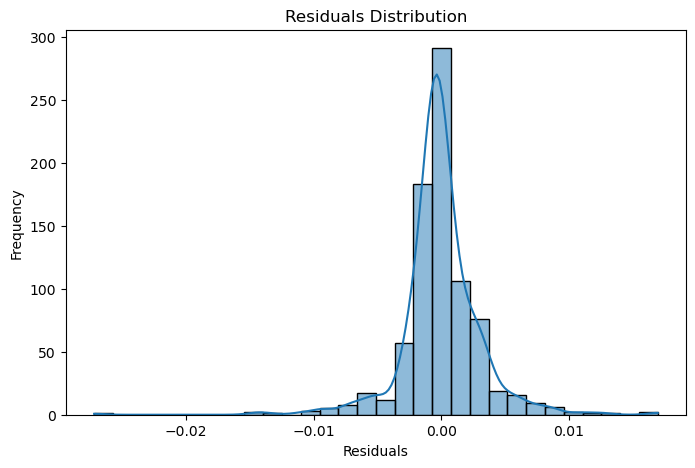

/var/folders/x6/k6smyqdj3lg6qmw8y7wds1jc0000gn/T/ipykernel_14000/2650808078.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--r', color='red')  # Line of perfect fit


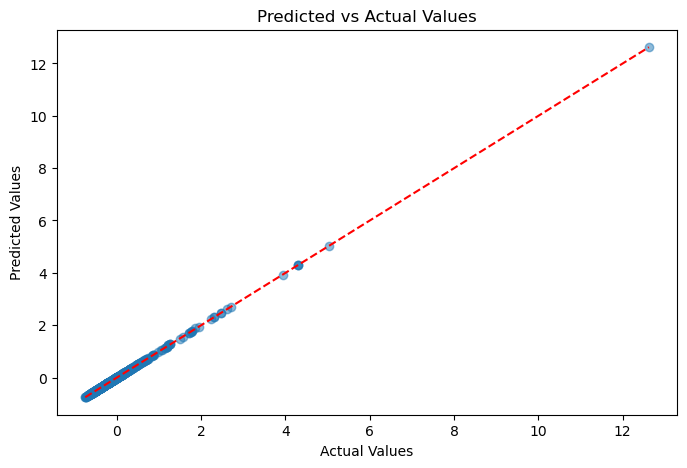

In [ ]:
from xgboost import XGBRegressor

# Initialize and train the XGBoost regression model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train_split, y_train_split)

# Predict on validation set
y_pred = model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

# Plot residuals
residuals = y_val - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()

# Scatter plot of predicted vs actual values
plt.figure(figsize=(8, 5))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--r', color='red')  # Line of perfect fit
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()


### Model Exploration and Evaluation

Consider what metrics you want to use to evaluate success.
- If you think about mean squared error, can we actually relate to the amount of error?
- Try root mean squared error so that error is closer to the original units (dollars)
- What does RMSE do to outliers?
- Is mean absolute error a good metric for this problem?
- What about R^2? Adjusted R^2?
- Briefly describe your reasons for picking the metrics you use

In [ ]:
# gather evaluation metrics and compare results

Linear Regression:
  Mean Squared Error (MSE): 0.004976686852610504
  Root Mean Squared Error (RMSE): 0.07054563666599448
  Mean Absolute Error (MAE): 0.02892913351800372
  R-squared (R²): 0.9908702910930688
--------------------------------------------------
Support Vector Regression:
  Mean Squared Error (MSE): 0.029507274875278915
  Root Mean Squared Error (RMSE): 0.17177681704839834
  Mean Absolute Error (MAE): 0.04155839337758862
  R-squared (R²): 0.945869041346897
--------------------------------------------------
Random Forest:
  Mean Squared Error (MSE): 1.621855987772967e-05
  Root Mean Squared Error (RMSE): 0.004027227318854707
  Mean Absolute Error (MAE): 0.0005172759822109871
  R-squared (R²): 0.9999702471272639
--------------------------------------------------
XGBoost:
  Mean Squared Error (MSE): 9.659712749004696e-06
  Root Mean Squared Error (RMSE): 0.0031080078424940783
  Mean Absolute Error (MAE): 0.0019194436811703676
  R-squared (R²): 0.9999822793018458
-------------

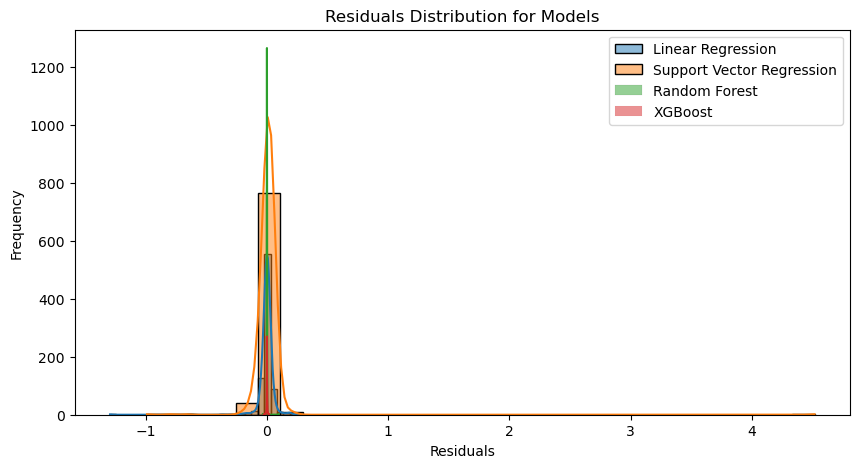

In [ ]:

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression": SVR(kernel='rbf'),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R^2": r2}

# Display results
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Mean Squared Error (MSE): {metrics['MSE']}")
    print(f"  Root Mean Squared Error (RMSE): {metrics['RMSE']}")
    print(f"  Mean Absolute Error (MAE): {metrics['MAE']}")
    print(f"  R-squared (R²): {metrics['R^2']}")
    print("-" * 50)

# Visualization of model performance
plt.figure(figsize=(10, 5))
for name, model in models.items():
    y_pred = model.predict(X_val)
    residuals = y_val - y_pred
    sns.histplot(residuals, bins=30, kde=True, label=name, alpha=0.5)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution for Models")
plt.legend()
plt.show()

# Explanation of Metrics:
# - MSE (Mean Squared Error) shows the average squared difference between actual and predicted values.
# - RMSE (Root Mean Squared Error) is in the same units as the target variable, making it more interpretable.
# - MAE (Mean Absolute Error) is less sensitive to outliers compared to RMSE.
# - R² (Coefficient of Determination) measures how well the model explains the variance in the data.
